# Réseaux de Neurones / Perceptrons multi-couche

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
import pickle
import time
from IPython.display import clear_output

La fonction **create_columns** creer des entête pour tous les colonne du fichier csv qui va nous permet d'extraire le colonne des label facilement.

In [3]:
def create_columns():
    cols = ['num']
    for i in range(784):
        cols.append(str(i+1))
    return cols
cols = create_columns()

La fonction **load_data**
prend 2 paramètres:
     <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; file: le chemins vers le fichier csv qui contient les données.
     <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; header: default None , None pour un fichier csv sans entête.
    
La fonction **load_data** lit le fichier dans 'file' et return un objet de type pandas.core.frame.Dataframe contenant les données du fichier csv.

Après la lecture des données nous allons utiliser la méthodes sample du class pandas.core.frame.DataFrame pour mélanger les données pour qu'on obtient à chaque fois des données differents.

La fonction **load_used_data** permet de charger les données utiliser dans ce test.

In [4]:
def load_data(file, header=None):
    mnist = pd.read_csv(file, header=header, names=cols)
    mnist = mnist.sample(frac=1).reset_index(drop=True)
    return mnist

In [5]:
def load_used_data():
    mnist = pd.read_csv('my_mnist.csv', index_col=0)
    return mnist

La fonction **divise_donnees** prend trois paramètre:
 <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   1- un variable de type pandas.core.frame.Dataframe contenant tous les données (apprentissage, test, et validation).
 <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   2- deuxiéme et troisiéme params sont des float quit représente le percentage 'p_appr' d'apprentissage, 'p_test' de test.

*1er étape* :La fonction génére 3 variable train, test, et val.
 <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   **train** contient les données d'apprentissage ( train = mnist[:appr] => de l'index 0 jusq'à lindex 'appr')
 <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   **test** contient les données du test (test = mnist[appr:tst] => de l'index 'appr' jusqu'à l'index 'tst')
 <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **val** contient les données de validation (ce qui reste de la dataframe)

*2éme étape*: La fonction extrait la colonne num ( 1er colonne) du variable train, test, val et les stocke dans les varibale trainY, testY et valY.

La fonction return trois tuples, chaque tuple contient les données et les labels d'apprentissage, test, et validation.

In [6]:
def divise_donnees(mnist, p_appr=0.8, p_test=0.1):
    appr = int(mnist.shape[0] * p_appr)
    tst = appr+int(mnist.shape[0] * p_test)

    train = mnist[:appr]
    test = mnist[appr:tst]
    val = mnist[tst:]
    
    print(train.shape)
    print (train.head())
    print (test.head())
    print (val.head())
    
    trainY = train.pop('num')
    testY = test.pop('num')
    valY = val.pop('num')
    train = train.values.reshape(train.shape[0], 28, 28, 1)
    test = test.values.reshape(test.shape[0], 28, 28, 1)
    val = val.values.reshape(val.shape[0], 28, 28, 1)
    train = train / 255.0
    test = test/ 255.0
    val = val/255.0
    return (train, trainY), (test, testY), (val, valY)

Nous faisons appelle à la fonction **load_data** pour charger le fichier "mnist_all.csv" placé dans le même répertoire que ce notebook.

In [9]:
mnist = load_data("mnist_all.csv")

In [10]:
print(mnist.shape)

(70000, 785)


Charger notre données avec la fonction **load_used_data()** .

In [11]:
mnist.to_csv('my_mnist.csv')

In [12]:
mnist = load_used_data()

In [13]:
(trainX, trainY), (testX, testY), (valX, valY) = divise_donnees(mnist)

(56000, 785)
   num  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  \
0    7  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1    6  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2    0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3    0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
4    4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   

   782  783  784  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0  

[5 rows x 785 columns]
       num  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  \
56000    0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
56001    6  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
56002    1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
56003    0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0

### Creation des modéles 

Le **model1** contient deux couche convolutionel:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1- couche avec 32 kernel de size 3x3 et format d'entré et un tableau de matrice de taille 28x28.
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2- couche avec 64 kernel de taille 3x3 et format d'entré et une matrice de taile 26x26.

Deuxieme couche et une couche de 128 noeuds, la fonction d'activation utiliser est "rectified linear unit".

La couche de sortie contient 10 noeuds.

Le Flatten ne prend aucun paramètre, car il n’y a besoin de rien de particulier pour mettre toutes les images bout à bout.

En revanche, le Dense qui sert à déclarer notre réseau de neurones artificiels prend en paramètre le nombre de neurones de la couche de sortie.

In [15]:
model1 = tf.keras.models.Sequential(name="model1")
model1.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1)))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), input_shape=(26, 26)))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model1.add(tf.keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model1.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

Le **model2** est une copie du model1 mais il contient deux couche cachées de 128 noeuds. 

la deuxieme couche cachée utilise tangent hyperbolique comme fonction d'activation


In [16]:
model2 = tf.keras.models.Sequential(name="model2")
model2.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1)))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), input_shape=(26, 26)))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model2.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128, activation=tf.nn.tanh))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

Pour **modéle3** les deux couche cachées utilise tangent hyperbolique comme fonction d'activation.


In [17]:
model3 = tf.keras.models.Sequential(name="model3")
model3.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1)))
model3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), input_shape=(26, 26)))
model3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(tf.keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model3.add(tf.keras.layers.Dense(128, activation=tf.nn.tanh))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(128, activation=tf.nn.tanh))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

Pour le **modéle4** les deux couche cachées utilise rectified linear unit comme fonction d'activation.

In [18]:
model4 = tf.keras.models.Sequential(name="model4")
model4.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1)))
model4.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), input_shape=(26, 26)))
model4.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model4.add(tf.keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model4.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

Dans cette partie nous allons compiler les 4 modèles en utilisant des différent optimizers et fonction de loss, evaluer et sauvegarder ces modéles dans un fichier qu'on a crée (saved_model) pour que nous puissions les réutiliser après la phase d’apprentissage sans avoir à relancer cette phase. et puis sauvegarder les données dans un fichier data.p. 

In [59]:
optimizers = ['adam', 'adamax', 'rmsprop']
epochs = [3, 5, 10]
batch_sizes = [None, 64, 256]

data = []

run = input('This process could take a lot of time are you sure you want run it (BETWEEN 7 AND 8 HOURS) [y|N]')

start = time.time()
i=0
if run == 'y':
    start = time.time()
    for optimizer in optimizers:
        for epoch in epochs:
            for batch_size in batch_sizes:
                
                # compiling all the models
                model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                model4.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                
                # trainning the models
                model1.fit(trainX, trainY, validation_data=(valX, valY), epochs=epoch, batch_size=batch_size)
                model2.fit(trainX, trainY, validation_data=(valX, valY), epochs=epoch, batch_size=batch_size)
                model3.fit(trainX, trainY, validation_data=(valX, valY), epochs=epoch, batch_size=batch_size)
                model4.fit(trainX, trainY, validation_data=(valX, valY), epochs=epoch, batch_size=batch_size)
                
                # evaluating the models
                loss1, acc1 = model1.evaluate(testX, testY)
                loss2, acc2 = model2.evaluate(testX, testY)
                loss3, acc3 = model3.evaluate(testX, testY)
                loss4, acc4 = model4.evaluate(testX, testY)
                
                # saving the models so we don't have to train them again
                model1.save('saved_model/'+model1.name+"_"+optimizer+"_"+str(batch_size)+"_"+str(epoch))
                model2.save('saved_model/'+model2.name+"_"+optimizer+"_"+str(batch_size)+"_"+str(epoch))
                model3.save('saved_model/'+model3.name+"_"+optimizer+"_"+str(batch_size)+"_"+str(epoch))
                model4.save('saved_model/'+model4.name+"_"+optimizer+"_"+str(batch_size)+"_"+str(epoch))
                                
                # saving the data
                info1 = {'model': model1.name, 'accuracy': acc1, 'loss': loss1, 'optimizer':optimizer, 'batch_size':batch_size, 'epochs':epoch}
                info2 = {'model': model2.name, 'accuracy': acc2, 'loss': loss2, 'optimizer':optimizer, 'batch_size':batch_size, 'epochs':epoch}
                info3 = {'model': model3.name, 'accuracy': acc3, 'loss': loss3, 'optimizer':optimizer, 'batch_size':batch_size, 'epochs':epoch}
                info4 = {'model': model4.name, 'accuracy': acc4, 'loss': loss4, 'optimizer':optimizer, 'batch_size':batch_size, 'epochs':epoch}
                
                data.append(info1)
                data.append(info2)
                data.append(info3)
                data.append(info4)
                clear_output()
                i+=4
                pickle.dump(data, open("data_notcomplete.p", "wb"))
                print(str(i)+'/108')
                
end = time.time()
print('execution time : ', end - start)
# saving data into a pickle file so we dont have to train all the models again
pickle.dump( data, open( "data.p", "wb" ))



108/108
execution time :  37472.74872922897


Charger notre modéles

In [20]:
data = pickle.load( open( "data.p", "rb" ))
print(data)

[{'model': 'model1', 'accuracy': 0.9875714182853699, 'loss': 0.04993966024888712, 'optimizer': 'adam', 'batch_size': None, 'epochs': 3}, {'model': 'model2', 'accuracy': 0.9855714440345764, 'loss': 0.0520970665847417, 'optimizer': 'adam', 'batch_size': None, 'epochs': 3}, {'model': 'model3', 'accuracy': 0.9858571290969849, 'loss': 0.04793939321428271, 'optimizer': 'adam', 'batch_size': None, 'epochs': 3}, {'model': 'model4', 'accuracy': 0.9868571162223816, 'loss': 0.04855320831614413, 'optimizer': 'adam', 'batch_size': None, 'epochs': 3}, {'model': 'model1', 'accuracy': 0.9895714521408081, 'loss': 0.039483296086097006, 'optimizer': 'adam', 'batch_size': 64, 'epochs': 3}, {'model': 'model2', 'accuracy': 0.9882857203483582, 'loss': 0.04669764697162568, 'optimizer': 'adam', 'batch_size': 64, 'epochs': 3}, {'model': 'model3', 'accuracy': 0.9875714182853699, 'loss': 0.051203603621538994, 'optimizer': 'adam', 'batch_size': 64, 'epochs': 3}, {'model': 'model4', 'accuracy': 0.9871428608894348, 

Afficher les élements qui ont une précision supérieure à 0.9921

In [21]:
best_info = {}
max_acc = -1
for info in data:
    if info['accuracy'] > 0.9921:
        print(info)
        
        

{'model': 'model1', 'accuracy': 0.9924286007881165, 'loss': 0.0790746036359165, 'optimizer': 'adamax', 'batch_size': 64, 'epochs': 3}
{'model': 'model1', 'accuracy': 0.9921428561210632, 'loss': 0.08170548778263464, 'optimizer': 'adamax', 'batch_size': 256, 'epochs': 3}
{'model': 'model1', 'accuracy': 0.9922857284545898, 'loss': 0.09389797186580769, 'optimizer': 'adamax', 'batch_size': 64, 'epochs': 5}
{'model': 'model1', 'accuracy': 0.9924286007881165, 'loss': 0.09184012696102455, 'optimizer': 'adamax', 'batch_size': 256, 'epochs': 10}
{'model': 'model1', 'accuracy': 0.9922857284545898, 'loss': 0.17110529520636705, 'optimizer': 'rmsprop', 'batch_size': None, 'epochs': 10}


### Affichage de l'évolution de l'égart et de la précision

La fonction **get_data** Compare les éléments et obtient les données demandé de notre data.


In [74]:
epochs_arr = [3, 5, 10]
batchs = [None, 64, 256]
optimizers=['adam', 'adamax', 'rmsprop']
def get_data(var, epochs=-1, batch_size=-1, optimizer=''):
    infos = []
    if var == 'o': # optimizers
        if not epochs in epochs_arr and not batch_size in batchs:
            print('please check your function arguments')
        else:
            for info in data:
                if info['epochs'] == epochs and info['batch_size'] == batch_size:
                    infos.append(info)
    elif var == 'b': # batch_size
        if not epochs in epochs_arr and not optimizer in optimezers :
            print('please check your function arguments')
        else:
            for info in data:
                if info['epochs'] == epochs and info['optimizer'] == optimizer:
                    infos.append(info)
    elif var == 'e': # epochs
        if not batch_size in batchs and not optimizer in optimizers :
            print('please check your function arguments')
        else:
            for info in data:
                if info['batch_size'] == batch_size and info['optimizer'] == optimizer:
                    infos.append(info)
    return infos

La fonction **plot()** nous permet de tracer l'évolution de l'égart (loss) et la précision (acc) des 4 modéles en fonction de l'optimizer, epochs et batch size.
La fonction nous permet de choisir notre variable:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"o" pour optimizers.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"e" pour epochs.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"b" pour batch size.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"c" pour cancel.<br>

et ensuite de choisir les autres éléments. 

In [92]:
def plot():
    
    plt.style.use('seaborn')
    font = {'family' : 'Arial',
            'size'   : 15}
    matplotlib.rc('font', **font)
    
    data = []
    optimizers = ['adam', 'adamax', 'rmsprop']
    variable = input('Please enter your varibale param [o: optimizer, b: batch_size, e: epochs, c: cancel]')
    while not variable in ['o', 'e', 'b', 'c']:
        variable = input('Please enter a valid char [o: optimizer, b: batch_size, e: epochs, c: cancel]')
    
    if variable == 'c':
        print('You are out!')
        return
    else:
        if variable == 'o':
            x_axis = ['adam', 'adamax', 'rmsprop']
            epochs = input('Please enter epochs : ')
            batch_size= input('Please enter batch size [0 for None] : ')
            if batch_size == '0':
                print('here')
                data = get_data(variable,  epochs = int(epochs), batch_size=None)
            else:
                data = get_data(variable,  epochs = int(epochs), batch_size=int(batch_size))
                
        elif variable == 'e':
            x_axis = [3,5,10]
            batch_size= input('Please enter batch size [0 for None] : ')
            optimizer = input('1 : adam, 2 : adamax, 3 : rmsprop [choose 1, 2, or 3]')
            if int(optimizer) < 4:
                if batch_size == '0':
                    data = get_data(variable, batch_size=None, optimizer=optimizers[int(optimizer) -1])
                else:
                    data = get_data(variable, batch_size=int(batch_size), optimizer=optimizers[int(optimizer) -1])
            else:
                print('Please next time select a number between 1 and 3')
        
        elif variable == 'b':
            x_axis = ['None', '64', '256']
            epochs = input('Please enter epochs : ')
            optimizer = input('1 : adam, 2 : adamax, 3 : rmsprop [choose 1, 2, or 3]')
            if int(optimizer) < 4:
                data = get_data(variable, epochs=int(epochs), optimizer=optimizers[int(optimizer) -1])
            else:
                print('Please next time select a number between 1 and 3')
                
        dataframe = pd.DataFrame(data)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
        subplots = [ax1, ax2, ax3, ax4]
        models = ['model1', 'model2', 'model3', 'model4']
        
    
        print(dataframe)
        

        for i in range(4):
            model = dataframe['model'] == models[i]
            acc = dataframe[model]['accuracy']
            loss = dataframe[model]['loss']
            subplots[i].plot(x_axis, acc, label='accuracy')
            subplots[i].plot(x_axis, loss, label='loss')
            subplots[i].legend()
            subplots[i].set_title('model '+str(i+1))
            subplots[i].set_ylabel('accuracy/loss')
            subplots[i].set_xlabel('optimizer')
    
        
    

Please enter your varibale param [o: optimizer, b: batch_size, e: epochs, c: cancel]o
Please enter epochs : 3
Please enter batch size [0 for None] : 256
     model  accuracy      loss optimizer  batch_size  epochs
0   model1  0.990857  0.039093      adam         256       3
1   model2  0.989143  0.052594      adam         256       3
2   model3  0.989286  0.042070      adam         256       3
3   model4  0.990286  0.040845      adam         256       3
4   model1  0.992143  0.081705    adamax         256       3
5   model2  0.991857  0.062956    adamax         256       3
6   model3  0.989143  0.063902    adamax         256       3
7   model4  0.990857  0.115299    adamax         256       3
8   model1  0.992000  0.122350   rmsprop         256       3
9   model2  0.990571  0.119096   rmsprop         256       3
10  model3  0.989857  0.094856   rmsprop         256       3
11  model4  0.990714  0.214597   rmsprop         256       3


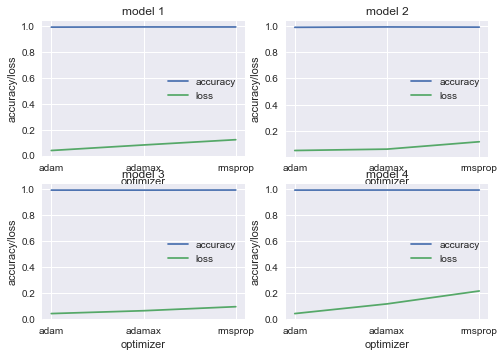

In [93]:
plot()